In [0]:
!pip install kaggle

    100% |████████████████████████████████| 61kB 2.6MB/s 
    100% |████████████████████████████████| 245kB 4.9MB/s 
  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /root/.cache/pip/wheels/8b/21/3b/a0076243c6ae12a6215b2da515fe06b539aee7217b406e510e
  Running setup.py bdist_wheel for python-slugify ... - done
  Stored in directory: /root/.cache/pip/wheels/e3/65/da/2045deea3098ed7471eca0e2460cfbd3fdfe8c1d6fa6fcac92
Successfully built kaggle python-slugify


In [0]:
#code pour utiliser kaggle api dans codelab, et telecharger les donne dans le serveur
#suivre les etapes dans le lien:
#https://medium.com/@move37timm/using-kaggle-api-for-google-colaboratory-d18645f93648
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions download -c ift3395-6390-f2018
!unzip -n train_images.npy.zip
!unzip -n test_images.npy.zip

  0% 0.00/121k [00:00<?, ?B/s]
100% 121k/121k [00:00<00:00, 38.0MB/s]
  0% 0.00/121k [00:00<?, ?B/s]
100% 121k/121k [00:00<00:00, 63.1MB/s]
100% 36.0M/36.1M [00:00<00:00, 35.6MB/s]
100% 36.1M/36.1M [00:00<00:00, 73.1MB/s]
 53% 19.0M/36.1M [00:00<00:00, 39.7MB/s]
100% 36.1M/36.1M [00:00<00:00, 112MB/s] 
Archive:  train_images.npy.zip
  inflating: train_images.npy        
Archive:  test_images.npy.zip
  inflating: test_images.npy         


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'




In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

tcmalloc: large alloc 1073750016 bytes == 0x58a0e000 @  0x7f17707d42a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641


In [0]:
#Load images with numpy
def randomize(a, b):
    #pris de:https://tech.pic-collage.com/tips-of-numpy-shuffle-multiple-arrays-e4fb3e7ae2a
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b
import torch
%pylab inline
images_train_raw = np.load('train_images.npy', encoding='latin1')
train_labels_raw = np.genfromtxt('train_labels.csv', names=True, delimiter=',', dtype=[('Id', 'i8'), ('Category', 'S5')])

#images_train_raw,train_labels_raw=randomize((images_train_raw),(train_labels_raw))



Populating the interactive namespace from numpy and matplotlib


In [0]:
# cette partie converti les donnes en tensor pour torch
#cette partie remplie la ram tres rapidement
#a ameliorer'
from collections import Counter
from scipy import ndimage
from skimage.filters.rank import entropy
from skimage.morphology import disk
torch.set_default_tensor_type('torch.DoubleTensor')
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
x_train =images_train_raw[:,1]
y_train =train_labels_raw
import cv2
import math


num_classes=31
def class_to_num(string):
    words=['sink','pear','moust','nose','skate','pengu','peanu','skull','panda','paint','nail','apple','rifle','mug','sailb','pinea','spoon','rabbi','shove','rolle','screw','scorp','rhino','pool','octag','pillo','parro','squig','mouth','empty','penci']
    return words.index(string.decode('UTF-8'))
def num_to_class(num):
    words=['sink','pear','moustache','nose','skateboard','penguin','peanut','skull','panda','paintbrush','nail','apple','rifle','mug','sailboat','pineapple','spoon','rabbit','shovel','rollerskates','screwdriver','scorpion','rhinoceros','pool','octagon','pillow','parrot','squiggle','mouth','empty','pencil',]
    return words[int(num)]
def cookie_cutter(center_coo,img,step):
    img_dim=img.shape[0]
    #cette partie prend le centre d'entropie et coupe un caree autour:
    coo1=min(img_dim-step*2,max(0,center_coo[0]-step))
    coo2=max(step*2 ,min(100,center_coo[0]+step))
    coo3=min(img_dim-step*2,max(0,center_coo[1]-step))
    coo4=max(step*2 ,min(100,center_coo[1]+step))
    image_cut=img[coo1:coo2,coo3:coo4]
    return image_cut
def entropy_cut(img):
    #from skimage.filters.rank import entropy
    #from skimage.morphology import disk
    temp=np.uint8(img)#converti en int pour la fn entropy() , mais le centre de l'image original est utilisee
    cann = cv2.bilateralFilter(temp,9,100,100)
    #temp_img=np.where(img > 40, 1, 0)
    ent=entropy(cann,disk(10))
    indx_1d =np.argmax(ent)
    ent_center=np.unravel_index(indx_1d, (100,100))#coordonnes du centre d'enropie
    cut=cookie_cutter(ent_center,img,15)
    return cut
def centroid_cut(img):
    
    center=ndimage.measurements.center_of_mass(img)
    
    cut=cookie_cutter((math.floor(center[0]),math.floor(center[1])),img,16)
    return cut
def uber_cut(img):
    temp=np.where(img > 40, 1, 0)
    num,contour=cv2.connectedComponents(np.uint8(temp))
    s_countours=np.array(contour).reshape((100,100))
    sec_common=Counter(s_countours.flatten()).most_common(2)[1][0]
    
    
    s_countours_max=np.where(s_countours== (sec_common), 1, 0)
    
    filled_contour_max=ndimage.morphology.binary_fill_holes(s_countours_max)
    
    #isolated_img= np.multiply(img+(np.ones((100,100))*50) , filled_contour_max)#version avec coloriage
    isolated_img= np.multiply(img , filled_contour_max)
    return centroid_cut(isolated_img)

num_train=x_train.shape[0]

inputX=[]
labelY=[]
for i in range(y_train.shape[0]):
    labelY.append(  class_to_num( y_train[i][1] ) )
    #print( y_train[i][1],class_to_num( y_train[i][1] ))
for i in range(x_train.shape[0]):
    temp=uber_cut(x_train[i].reshape(100,100)).flatten()
    #temp=x_train[i]
    inputX.append( np.array(temp.tolist()))#.reshape(1,100,100)


from sklearn.preprocessing import OneHotEncoder
one_hot = OneHotEncoder(n_values=num_classes, sparse=False)
#y_train = one_hot.fit_transform(np.array([labelY]).reshape(-1,1))
#y_test = one_hot.transform(np.array([labelPrimeY]).reshape(-1,1))





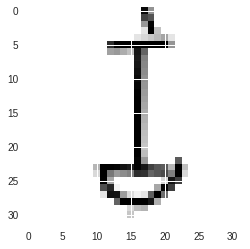

(0, b'shove')


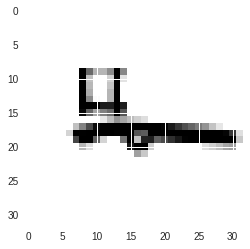

(1, b'rifle')


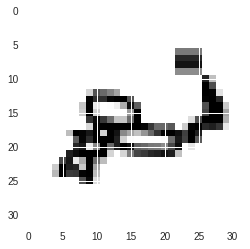

(2, b'scorp')


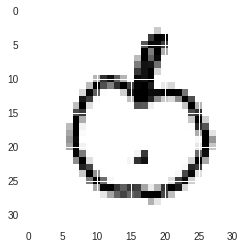

(3, b'apple')


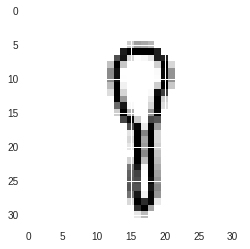

(4, b'spoon')


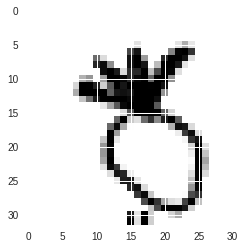

(5, b'pinea')


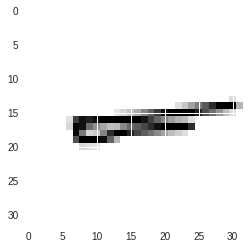

(6, b'rifle')


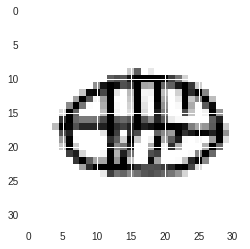

(7, b'mouth')


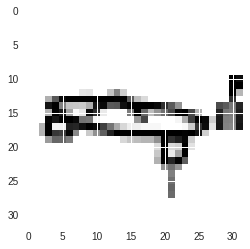

(8, b'skate')


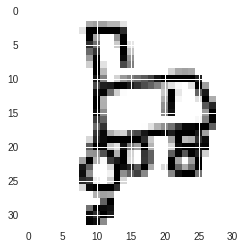

(9, b'rolle')


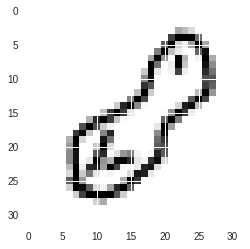

(10, b'peanu')


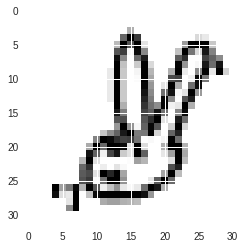

(11, b'rabbi')


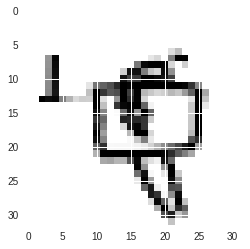

(12, b'sink')


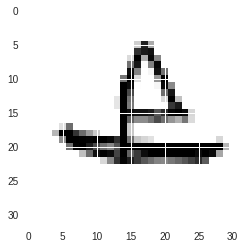

(13, b'sailb')


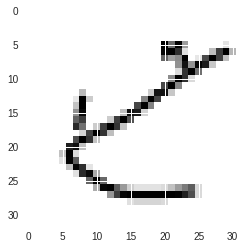

(14, b'nose')


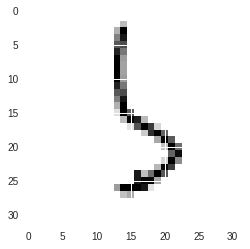

(15, b'nose')


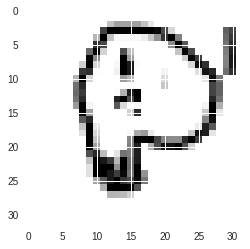

(16, b'skull')


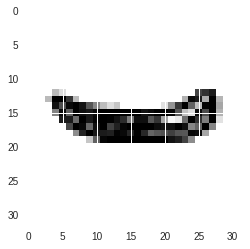

(17, b'mouth')


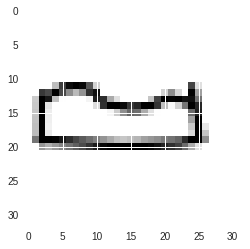

(18, b'pool')


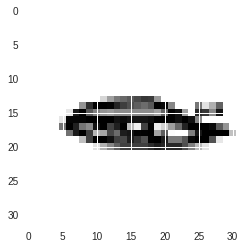

(19, b'mouth')


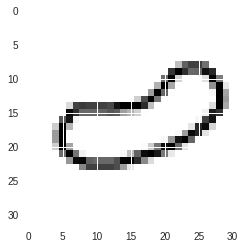

(20, b'peanu')


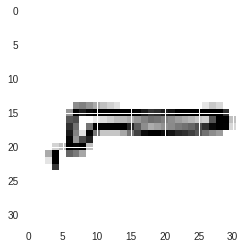

(21, b'rifle')


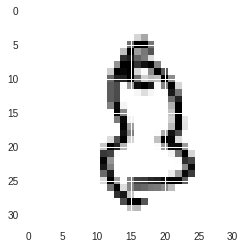

(22, b'pear')


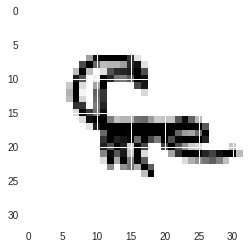

(23, b'scorp')


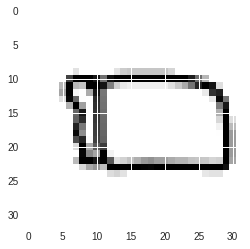

(24, b'pillo')


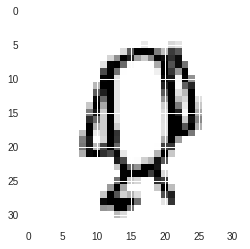

(25, b'pengu')


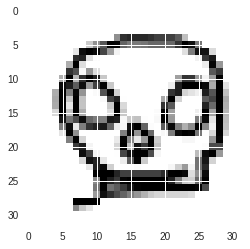

(26, b'skull')


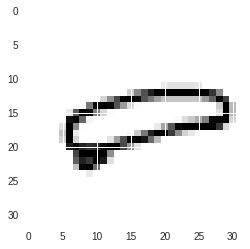

(27, b'skate')


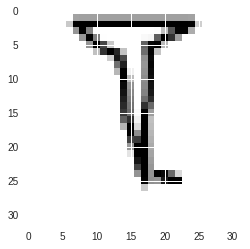

(28, b'nail')


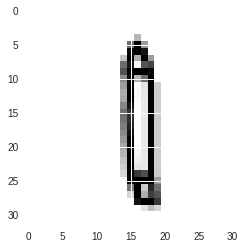

(29, b'penci')


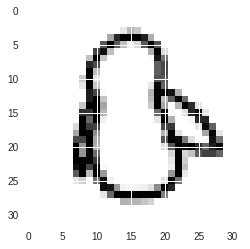

(30, b'pengu')


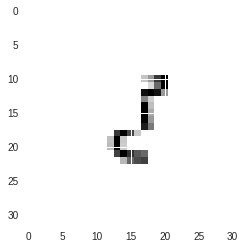

(31, b'empty')


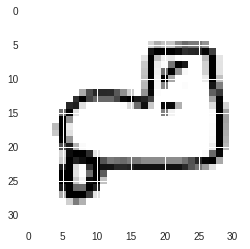

(32, b'rolle')


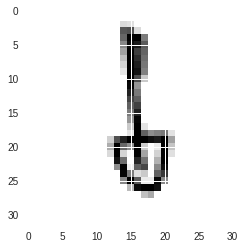

(33, b'shove')


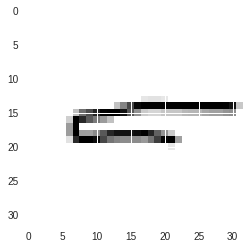

(34, b'rifle')


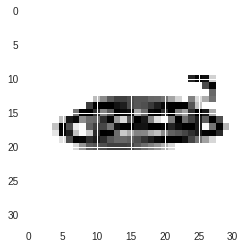

(35, b'pool')


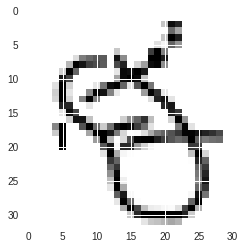

(36, b'peanu')


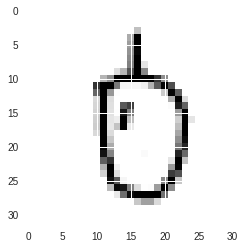

(37, b'pear')


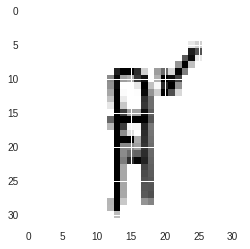

(38, b'nail')


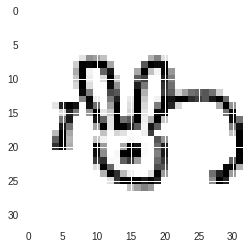

(39, b'rabbi')


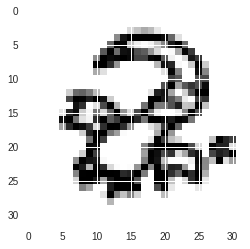

(40, b'scorp')


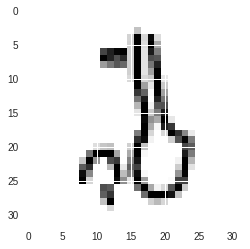

(41, b'spoon')


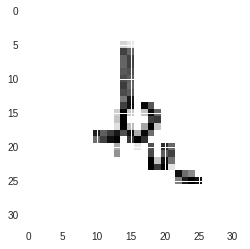

(42, b'spoon')


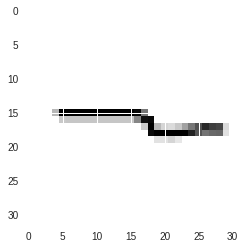

(43, b'rifle')


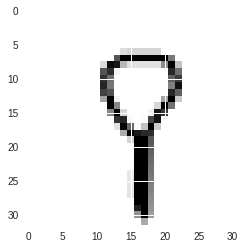

(44, b'spoon')


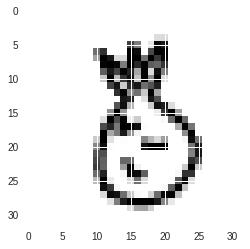

(45, b'pinea')


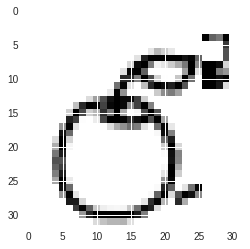

(46, b'apple')


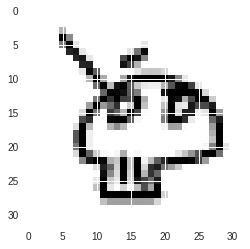

(47, b'skull')


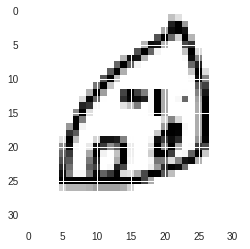

(48, b'nose')


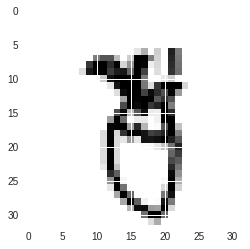

(49, b'pinea')


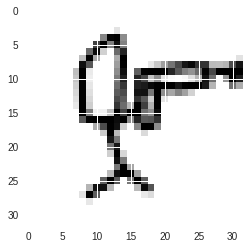

(50, b'rifle')


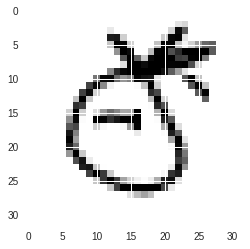

(51, b'pinea')


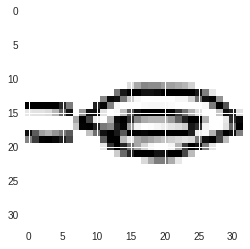

(52, b'mouth')


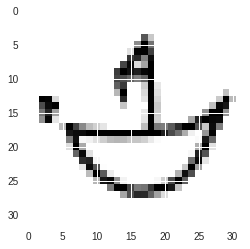

(53, b'sailb')


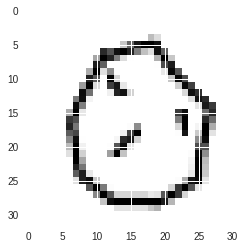

(54, b'octag')


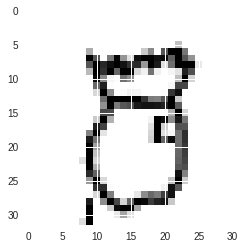

(55, b'pinea')


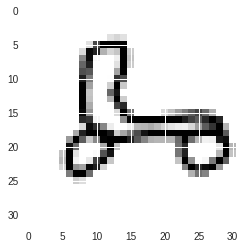

(56, b'rolle')


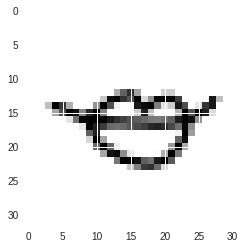

(57, b'mouth')


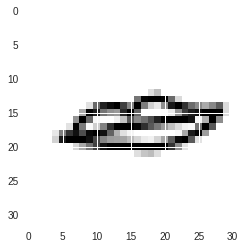

(58, b'mouth')


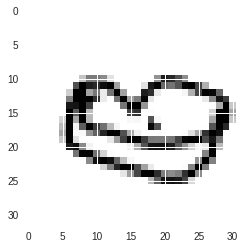

(59, b'mouth')


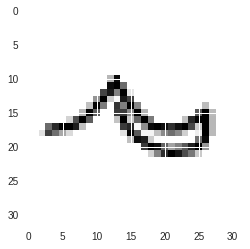

(60, b'moust')


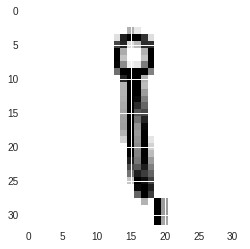

(61, b'spoon')


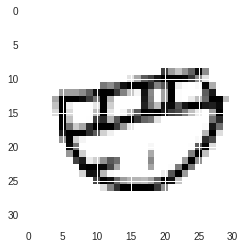

(62, b'mouth')


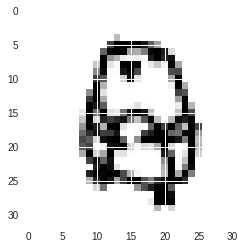

(63, b'pengu')


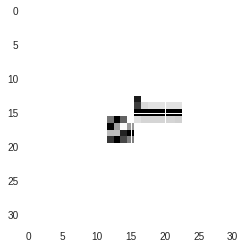

(64, b'empty')


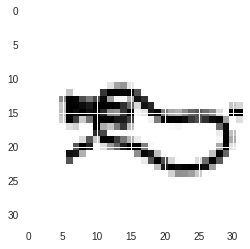

(65, b'pool')


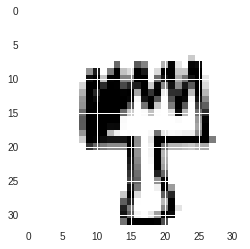

(66, b'paint')


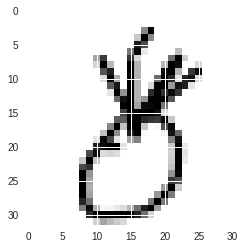

(67, b'pinea')


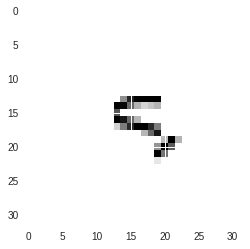

(68, b'empty')


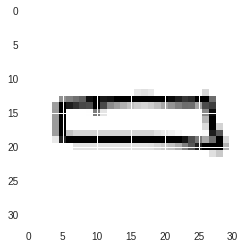

(69, b'pool')


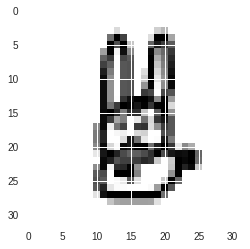

(70, b'rabbi')


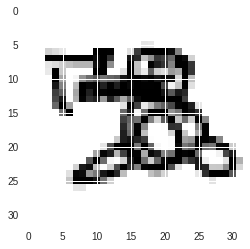

(71, b'panda')


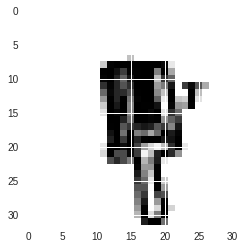

(72, b'paint')


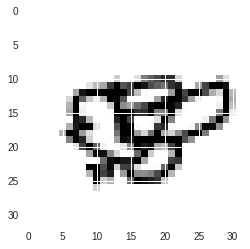

(73, b'scorp')


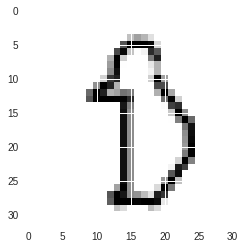

(74, b'pengu')


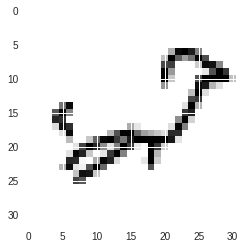

(75, b'parro')


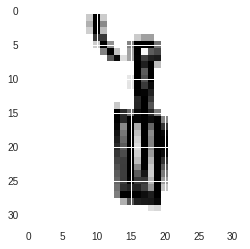

(76, b'screw')


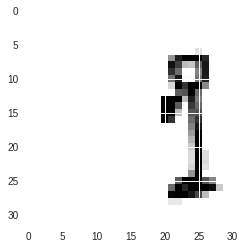

(77, b'shove')


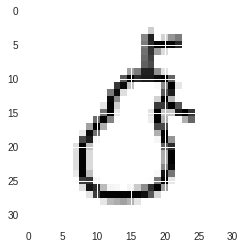

(78, b'pear')


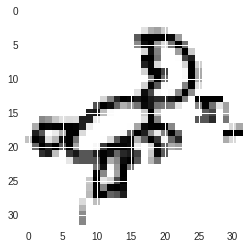

(79, b'scorp')


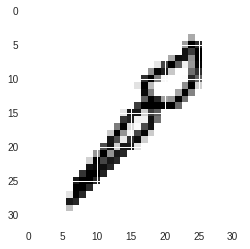

(80, b'paint')


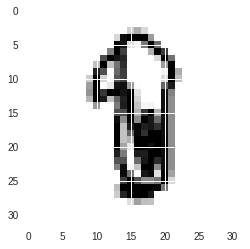

(81, b'parro')


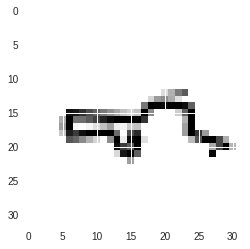

(82, b'rifle')


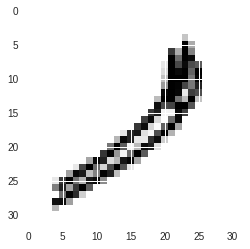

(83, b'paint')


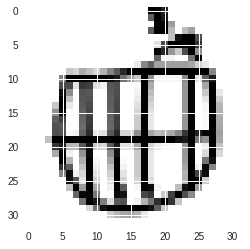

(84, b'mouth')


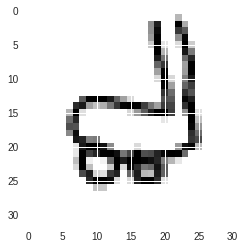

(85, b'rolle')


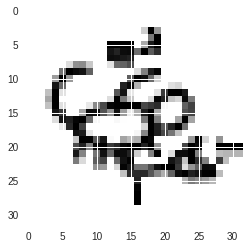

(86, b'scorp')


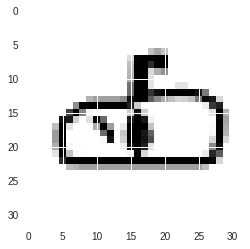

(87, b'sink')


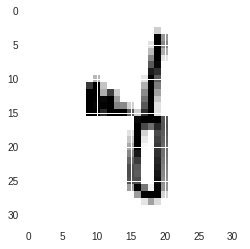

(88, b'screw')


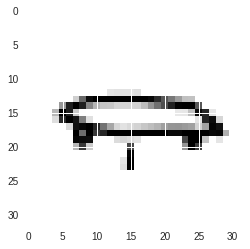

(89, b'skate')


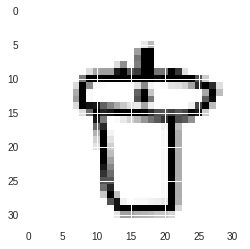

(90, b'sink')


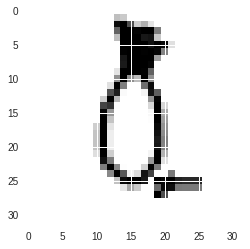

(91, b'pinea')


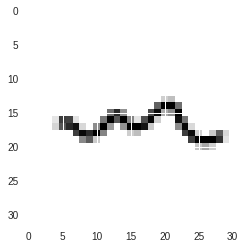

(92, b'squig')


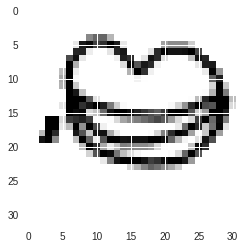

(93, b'mouth')


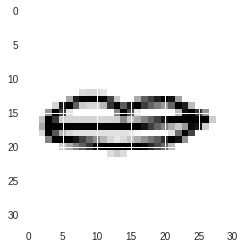

(94, b'mouth')


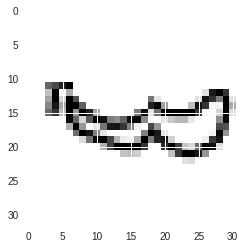

(95, b'moust')


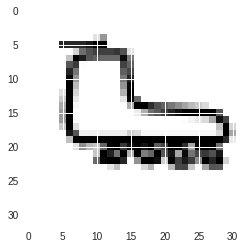

(96, b'rolle')


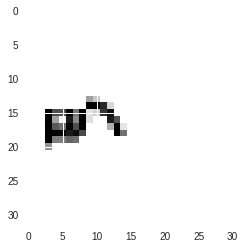

(97, b'empty')


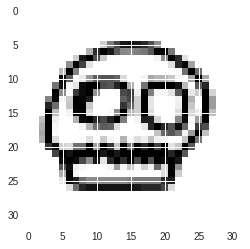

(98, b'skull')


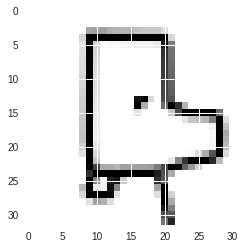

(99, b'rolle')


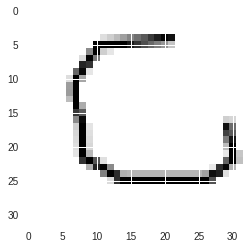

(100, b'octag')


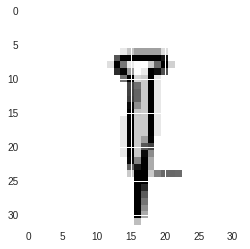

(101, b'nail')


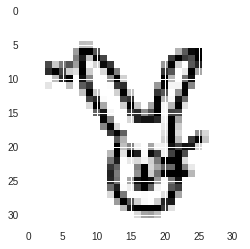

(102, b'rabbi')


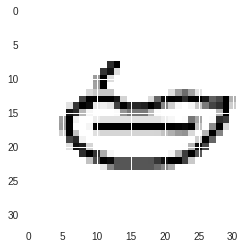

(103, b'mouth')


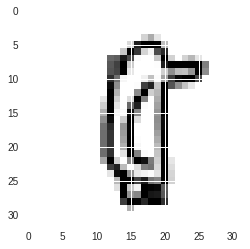

(104, b'parro')


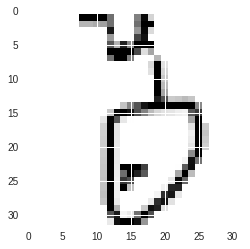

(105, b'pear')


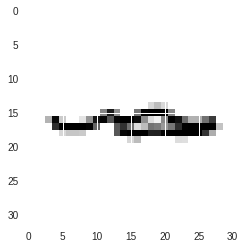

(106, b'moust')


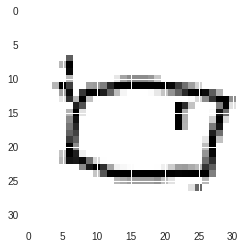

(107, b'pillo')


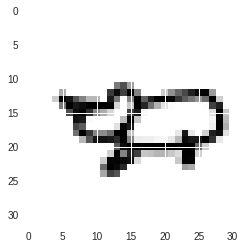

(108, b'rhino')


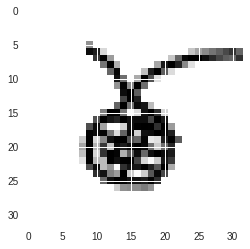

(109, b'pinea')


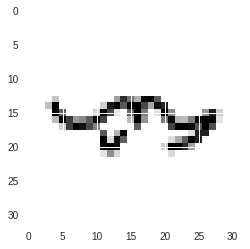

(110, b'moust')


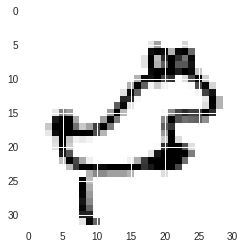

(111, b'rabbi')


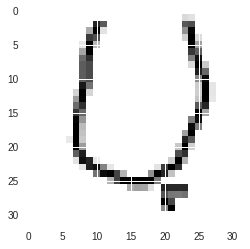

(112, b'nose')


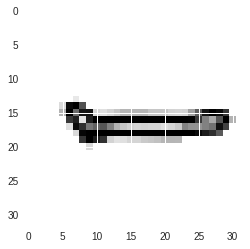

(113, b'skate')


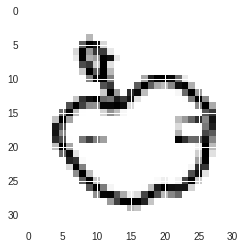

(114, b'apple')


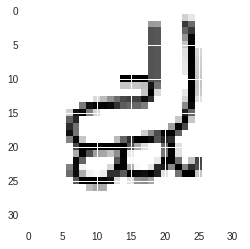

(115, b'rolle')


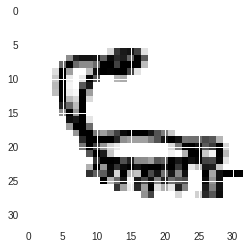

(116, b'scorp')


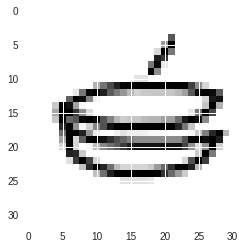

(117, b'mouth')


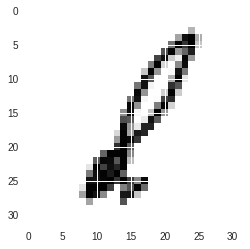

(118, b'paint')


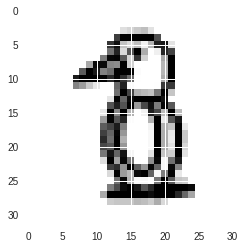

(119, b'pengu')


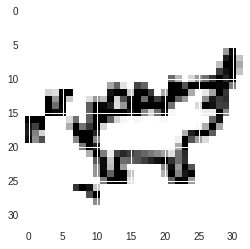

(120, b'rhino')


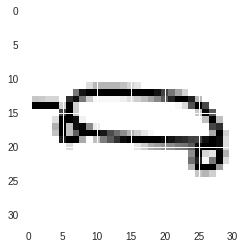

(121, b'skate')


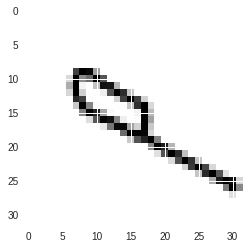

(122, b'screw')


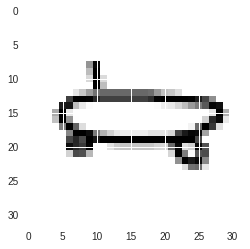

(123, b'skate')


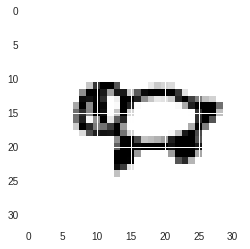

(124, b'rabbi')


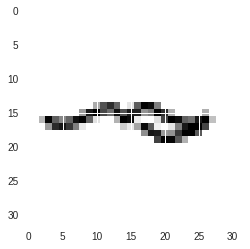

(125, b'moust')


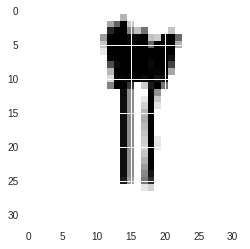

(126, b'paint')


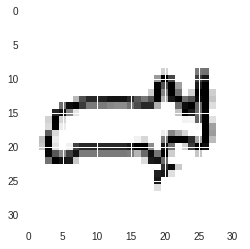

(127, b'rhino')


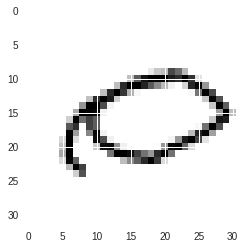

(128, b'nail')


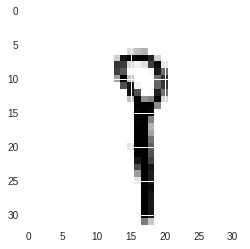

(129, b'screw')


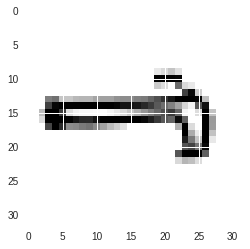

(130, b'rifle')


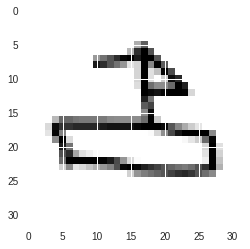

(131, b'sailb')


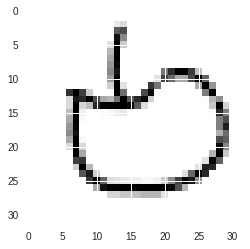

(132, b'apple')


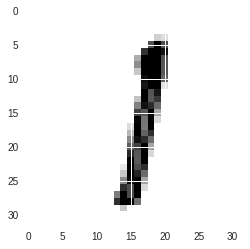

(133, b'paint')


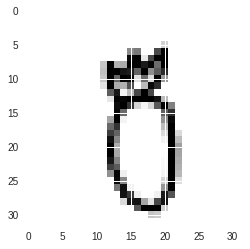

(134, b'pinea')


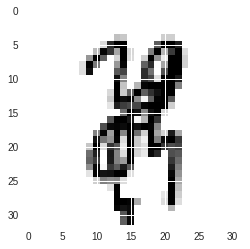

(135, b'squig')


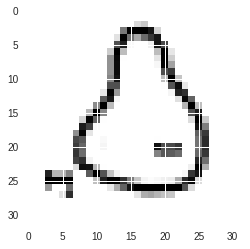

(136, b'pear')


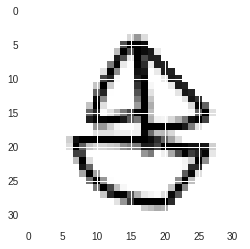

(137, b'sailb')


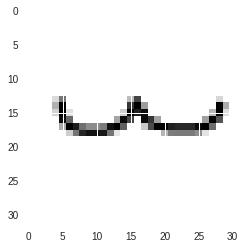

(138, b'moust')


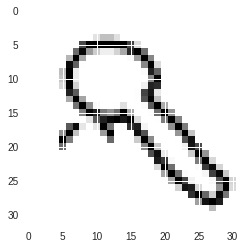

(139, b'spoon')


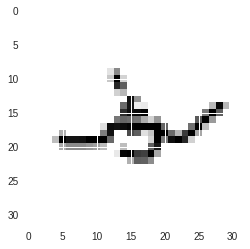

(140, b'moust')


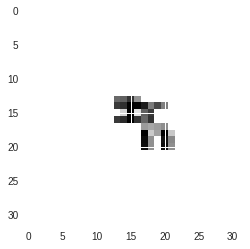

(141, b'empty')


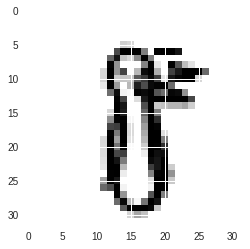

(142, b'pengu')


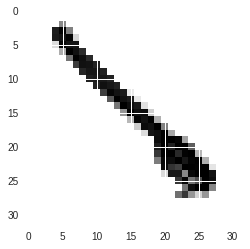

(143, b'paint')


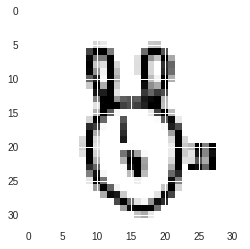

(144, b'rabbi')


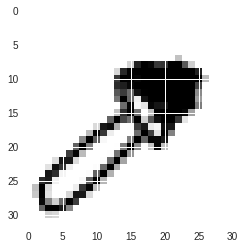

(145, b'paint')


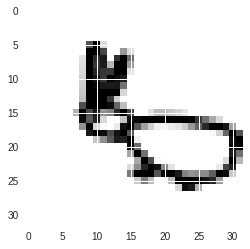

(146, b'rabbi')


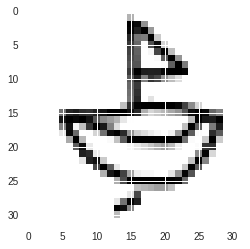

(147, b'sailb')


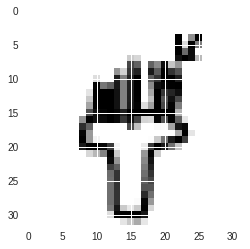

(148, b'paint')


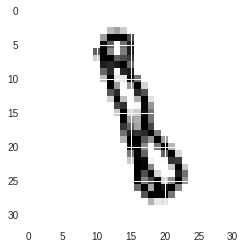

(149, b'shove')


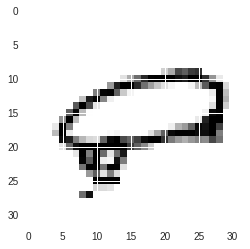

(150, b'skate')


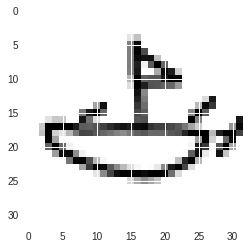

(151, b'sailb')


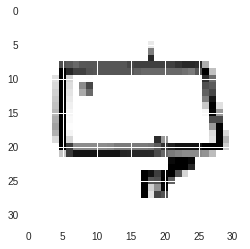

(152, b'pool')


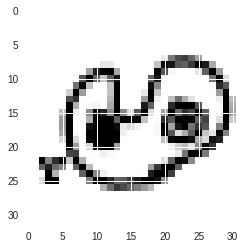

(153, b'panda')


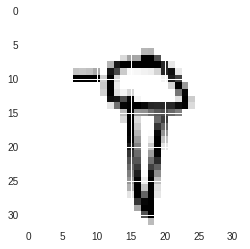

(154, b'nail')


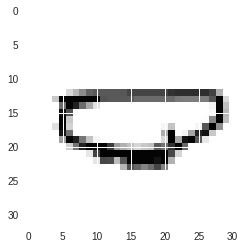

(155, b'skate')


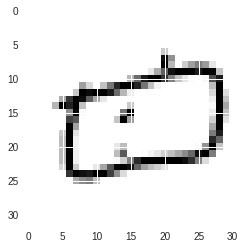

(156, b'pillo')


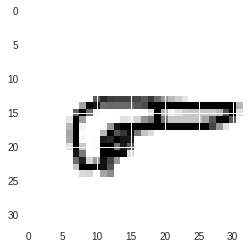

(157, b'rifle')


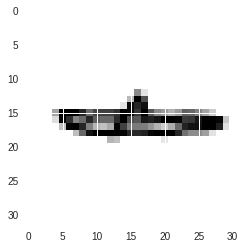

(158, b'sailb')


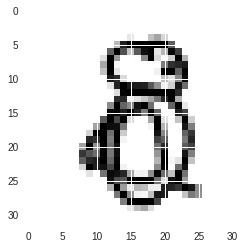

(159, b'pengu')


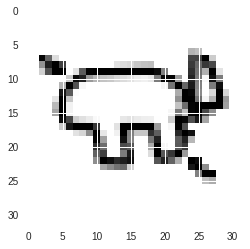

(160, b'rhino')


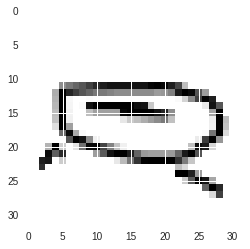

(161, b'pool')


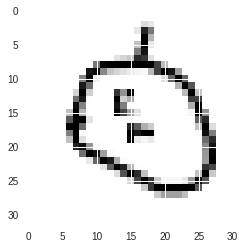

(162, b'apple')


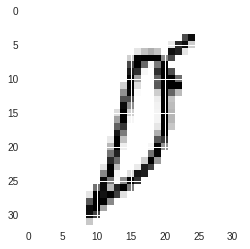

(163, b'parro')


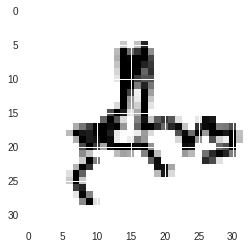

(164, b'rabbi')


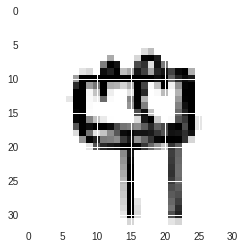

(165, b'sink')


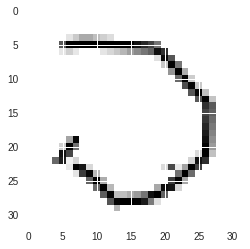

(166, b'octag')


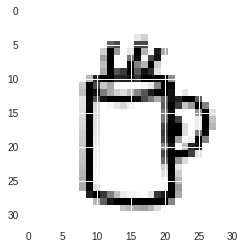

(167, b'mug')


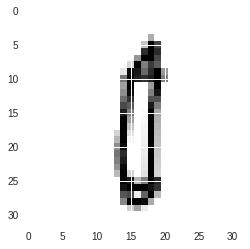

(168, b'penci')


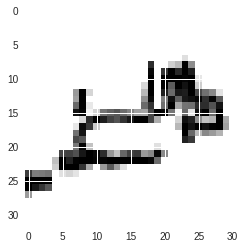

(169, b'rabbi')


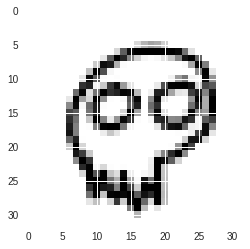

(170, b'skull')


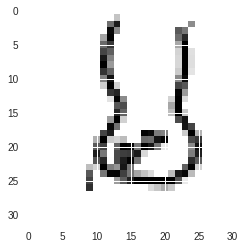

(171, b'nose')


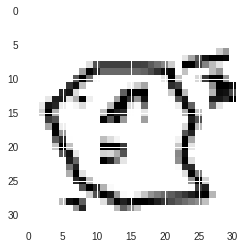

(172, b'octag')


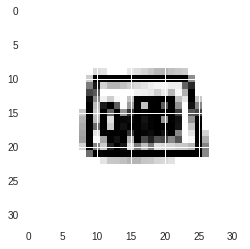

(173, b'skull')


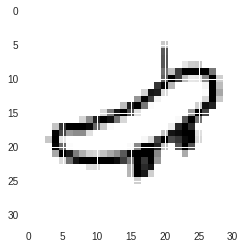

(174, b'skate')


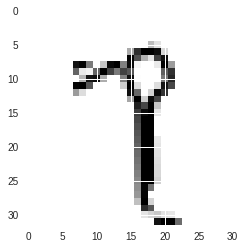

(175, b'spoon')


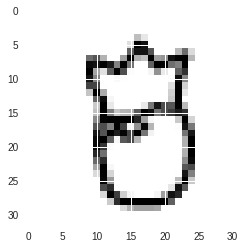

(176, b'pinea')


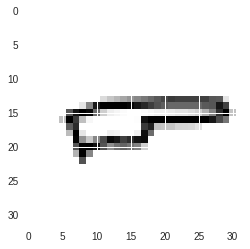

(177, b'rifle')


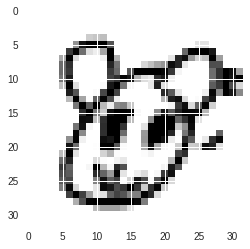

(178, b'panda')


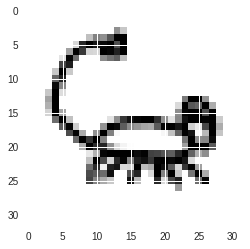

(179, b'scorp')


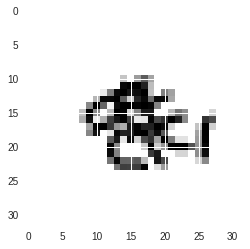

(180, b'squig')


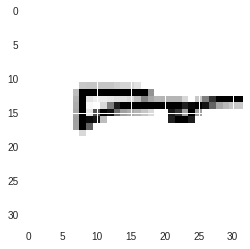

(181, b'rifle')


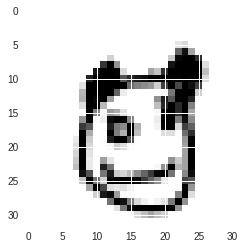

(182, b'panda')


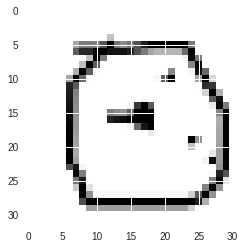

(183, b'octag')


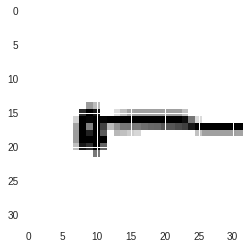

(184, b'nail')


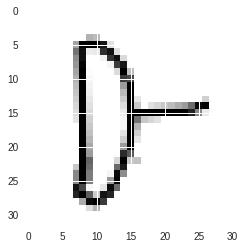

(185, b'shove')


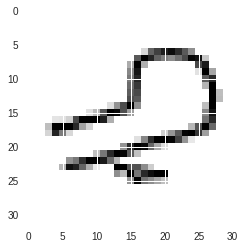

(186, b'spoon')


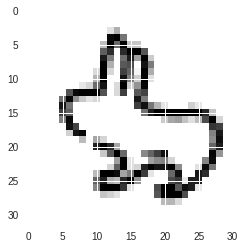

(187, b'rabbi')


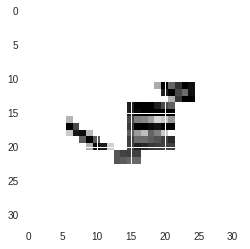

(188, b'empty')


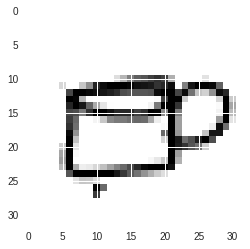

(189, b'mug')


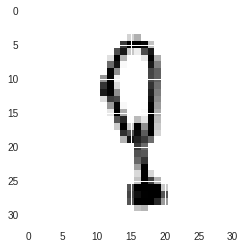

(190, b'screw')


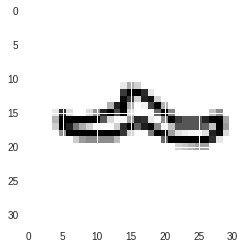

(191, b'moust')


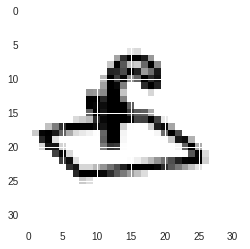

(192, b'sink')


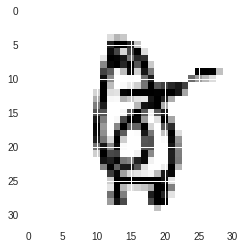

(193, b'pengu')


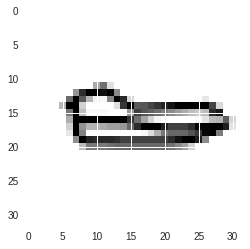

(194, b'mouth')


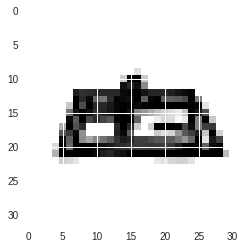

(195, b'sink')


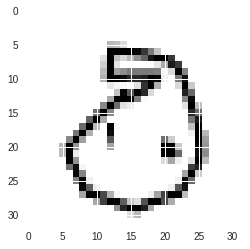

(196, b'octag')


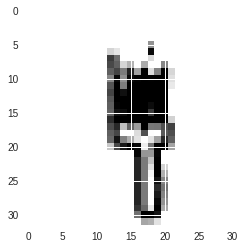

(197, b'paint')


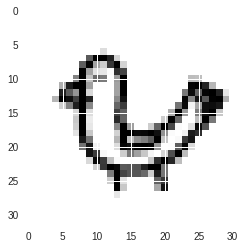

(198, b'parro')


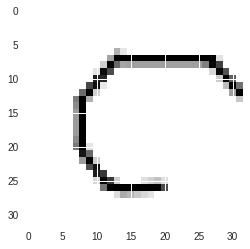

(199, b'octag')


In [0]:
#pour voir si le reperage des dessins et decoupage se passe bien:
for i in range(200):
    image_ = inputX[i].reshape(32,32)
    plt.imshow(image_)
    plt.show() 
    print(train_labels_raw[i])

In [0]:
import torch
from torch.utils import data
import torchvision.transforms as transforms
class myDataset(data.Dataset):

  def __init__(self, X, y,transf):
        self.transf=transf
        self.y = y
        self.X = X.reshape(-1, 1, 32, 32)
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X)
            
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)

  def __len__(self):

        return len(self.y)

  def __getitem__(self, index):
        # Load data and get label
        X = self.X
        y = self.y

        return (self.transf(torch.from_numpy(X[index].cpu().numpy().astype(np.float32))
).double(), y[index])


In [0]:
"""
ZONE TEST
pris de https://conorsdatablog.wordpress.com/2018/05/03/up-and-running-with-pytorch-minibatching-dataloading-and-model-building/
from torchvision import datasets, transforms
params = {'batch_size': 64,
          'shuffle': False}

train_generator = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
   **params)
for batch_idx, (data, target) in enumerate(train_generator):
    print("id ",batch_idx)
    print("data ",data)
    print("target ",target)
"""

'\nZONE TEST\npris de https://conorsdatablog.wordpress.com/2018/05/03/up-and-running-with-pytorch-minibatching-dataloading-and-model-building/\nfrom torchvision import datasets, transforms\nparams = {\'batch_size\': 64,\n          \'shuffle\': False}\n\ntrain_generator = torch.utils.data.DataLoader(\n    datasets.MNIST(\'../data\', train=True, download=True,\n                   transform=transforms.Compose([\n                       transforms.ToTensor(),\n                       transforms.Normalize((0.1307,), (0.3081,))\n                   ])),\n   **params)\nfor batch_idx, (data, target) in enumerate(train_generator):\n    print("id ",batch_idx)\n    print("data ",data)\n    print("target ",target)\n'

In [0]:
"""
#ZONE TEST
train_loader=myDataset(x_train,y_train)
params = {'batch_size':2,
          'shuffle': False}

train_generator =  torch.utils.data.DataLoader(train_loader, **params)
for batch_idx, (data, target) in enumerate(train_generator):
    print("id ",batch_idx)
    print("data ",data)
    print("target ",target)
    print("shape", data.shape)
"""

'\n#ZONE TEST\ntrain_loader=myDataset(x_train,y_train)\nparams = {\'batch_size\':2,\n          \'shuffle\': False}\n\ntrain_generator =  torch.utils.data.DataLoader(train_loader, **params)\nfor batch_idx, (data, target) in enumerate(train_generator):\n    print("id ",batch_idx)\n    print("data ",data)\n    print("target ",target)\n    print("shape", data.shape)\n'

In [0]:
import torch
torch.cuda.device_count()

1

In [0]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=2 ,stride = 2 ),
            nn.BatchNorm2d(64),
            nn.ReLU()
            
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64,64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.Dropout2d(0.25)
            #nn.MaxPool2d(2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
            #nn.MaxPool2d(2)
        )
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.25),
            nn.MaxPool2d(2)
        )
        self.layer5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
            
        )
        self.layer6 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(), 
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25)
        )
        self.layer7 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(), 
            nn.MaxPool2d(2)
        )
        
        
        self.fc1 = nn.Linear(1024, 700)
        self.bn=nn.BatchNorm1d(700)
        self.dropout=nn.Dropout(0.5)
        self.fcF = nn.Linear(700, 31)
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        
        
        out = out.view(out.size(0), -1)
        out = F.relu(self.bn(self.fc1(out)))
        out = self.dropout(out)
        out = self.fcF(out)
        return out



def train(model, device, train_loader, optimizer, epoch, loss_fn):
    #fonction pris de la demo 10
    model.train()
    train_losses=[]
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model((data))
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        if batch_idx % 10== 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item())) 
    return train_losses
def test(model, device, test_loader, loss_fn):
    #fonction pris de la demo 10
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model((data))
            test_loss += loss_fn(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return ( correct / len(test_loader.dataset))

def predict(model, device, test_loader):
    model.eval()
    list_predictions=[]
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            output = model((data))
            pred = output.max(1, keepdim=False)[1]
            list_predictions.append(pred)
    return list_predictions
# HYPERPARAMETERS TO PLAY WITH

# device = torch.device("cpu")

learning_rate = 0.01
epochs =55

from sklearn.model_selection import StratifiedKFold
params = {'batch_size':64,
              'shuffle': True}
paramsTest = {'batch_size': 512,
              'shuffle': False}


device = torch.device('cuda')
def adjust_lr(optimizer, epoch):
    
    lr = learning_rate * (0.2 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [0]:




def train_test_model(train_index, test_index):
    
    
    x_train = torch.from_numpy(np.array(inputX)[train_index]).to(device)
    x_test = torch.from_numpy(np.array(inputX)[test_index]).to(device)
    
    y_train = torch.from_numpy(np.array(labelY)[train_index] ).to(device)
    y_test = torch.from_numpy(np.array(labelY)[test_index] ).to(device)
    
    from sklearn.utils import class_weight
    #cette variable contient les poids pour blancer les classes
    class_wg=class_weight.compute_class_weight('balanced',np.arange(31), np.array(labelY)[train_index])
    class_wg_tensor=torch.from_numpy(np.array(class_wg)).to(device)
    
    
    model =CNN().to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)



    loss_fn = nn.CrossEntropyLoss(weight=class_wg_tensor)
    test_loss_fn = nn.CrossEntropyLoss(reduction='sum')


    # data loading
    
    train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.RandomRotation((-20,20)),
        transforms.RandomAffine(0,scale=(0.87,1.1),shear=(-8,8)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    train_generator = torch.utils.data.DataLoader(train_loader, **params)
    
    nd_train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    nd_train_generator = torch.utils.data.DataLoader(nd_train_loader, **params)
    
    test_loader=myDataset(x_test,y_test,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
    test_generator = torch.utils.data.DataLoader(test_loader, **paramsTest)

    # training
    results=[]
    for epoch in range(1, epochs):
        #adjust_lr(optimizer, epoch)#desactiver pour adam
        train(model, device, train_generator, optimizer, epoch, loss_fn)
        epoch_train_accuracy=test(model, device, nd_train_generator, test_loss_fn)
        epoch_test_accuracy=test(model, device, test_generator, test_loss_fn)
        
        results.append((epoch_train_accuracy,epoch_test_accuracy))
    del x_train, x_test, y_train, y_test,model#liberation de la memoire (:
    return results
    
skf = StratifiedKFold(n_splits=5)
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor, as_completed

pool = ThreadPoolExecutor(1)
futures = []
result_arr=[]
for train_i, test_i in skf.split(inputX, labelY):
    result_arr.append(train_test_model(train_i, test_i))
    break #efface break pour validation croisee

#for j in as_completed(futures):
#    print(j.result())
#np.mean(np.array(futures),axis=0)
#refaire entrainement sans tests

Train Epoch: 1 [0/7987 (0%)]	Loss: 3.540039
Train Epoch: 1 [640/7987 (8%)]	Loss: 3.839289
Train Epoch: 1 [1280/7987 (16%)]	Loss: 3.389163
Train Epoch: 1 [1920/7987 (24%)]	Loss: 3.417332
Train Epoch: 1 [2560/7987 (32%)]	Loss: 3.679988
Train Epoch: 1 [3200/7987 (40%)]	Loss: 3.209030
Train Epoch: 1 [3840/7987 (48%)]	Loss: 3.113688
Train Epoch: 1 [4480/7987 (56%)]	Loss: 3.142003
Train Epoch: 1 [5120/7987 (64%)]	Loss: 2.839230
Train Epoch: 1 [5760/7987 (72%)]	Loss: 2.969395
Train Epoch: 1 [6400/7987 (80%)]	Loss: 3.155974
Train Epoch: 1 [7040/7987 (88%)]	Loss: 2.790832
Train Epoch: 1 [7680/7987 (96%)]	Loss: 2.559278

Test set: Average loss: 2.6840, Accuracy: 1629/7987 (20.396%)


Test set: Average loss: 2.6928, Accuracy: 390/2013 (19.374%)

Train Epoch: 2 [0/7987 (0%)]	Loss: 2.996536
Train Epoch: 2 [640/7987 (8%)]	Loss: 2.878950
Train Epoch: 2 [1280/7987 (16%)]	Loss: 2.404630
Train Epoch: 2 [1920/7987 (24%)]	Loss: 2.587685
Train Epoch: 2 [2560/7987 (32%)]	Loss: 2.608802
Train Epoch: 2 [3200/

In [0]:
plt.xlabel('epochs')
plt.ylabel('performance')
test=[]
train=[]
for i in range(len(result_arr[0])):
    train.append(result_arr[0][i][0])
    test.append(result_arr[0][i][1])
print(test)
plt.plot(range(epochs-1), train, 'b', label='Train')
plt.plot(range(epochs-1),test , 'r', label='Test')
plt.legend(loc='best')
plt.show()

In [0]:
#visualisation des poids
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        print(m.weights.data)

In [0]:

#resultat du k-fold cross-validation:
#imprime le pourcentage correcte moyen des predictions par epoch


#for i in range(5):
#  result_arr.append(futures[i].result())
np.mean(np.array(result_arr),axis=0)

In [0]:

images_test_raw = np.load('test_images.npy', encoding='latin1')
images_test=images_test_raw
images_test.shape






In [0]:
#cette partie refait entrainement sur 100% des donnes 
x_train = torch.from_numpy(np.array(inputX)).to(device)
y_train = torch.from_numpy(np.array(labelY) ).to(device)
from sklearn.utils import class_weight
#cette variable contient les poids pour blancer les classes
class_wg=class_weight.compute_class_weight('balanced',np.arange(31), np.array(labelY))
class_wg_tensor=torch.from_numpy(np.array(class_wg)).to(device)


model =CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(weight=class_wg_tensor)
test_loss_fn = nn.CrossEntropyLoss(reduction='sum')
# data loading
train_loader=myDataset(x_train,y_train,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.RandomAffine(0,scale=(0.87,1.1),shear=(-8,8)),
        transforms.RandomRotation((-20,20)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
train_generator = torch.utils.data.DataLoader(train_loader, **params)
# training
for epoch in range(1, epochs):
    #adjust_lr(optimizer, epoch)
    train(model, device, train_generator, optimizer, epoch, loss_fn)

In [0]:
#cette partie fait les prediction sur l'ensembre de test
x_test_final =images_test[:,1]




inputPrimeX=[]
for i in range(x_test_final.shape[0]):
    temp=uber_cut(x_test_final[i].reshape(100,100)).flatten()
    #temp=x_test_final[i]
    inputPrimeX.append(np.array(temp.tolist()))#.reshape(1,100,100)
    
    
x_test_final = torch.from_numpy(np.array(inputPrimeX)).to(device)
paramsTestFinal = {'batch_size': 1,
          'shuffle': False}

final_test_loader=myDataset(x_test_final,x_test_final,transforms.Compose([        
        transforms.ToPILImage(),
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.5,],std=[0.5,]) 
        ]))
final_test_generator = torch.utils.data.DataLoader(final_test_loader, **paramsTestFinal)


pred_result=predict(model, device, final_test_generator)
print(pred_result)

In [0]:
#cette partie affiche les images et leur prediction, pour voir si le reseau donne des resultats
#qui on du sens
for i in range(100):
    image_ = (inputPrimeX[i]).reshape(32,32)
    plt.imshow(image_)
    plt.show() 
    print("pred: ",pred_result[i].tolist()[0],num_to_class( pred_result[i].tolist()[0] ) )
    print("^id^: ",i)


In [0]:
#imprime les donnes a copier/coller sur le fichier a remettre sur kaggle
print('Id,Category')
for i in range(10000):
    print(str(i)+','+str(num_to_class(pred_result[i].tolist()[0])) )
    
